In [29]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, EDMD, DMD, KERDMD, HODMD
import matplotlib.pyplot as plt
import scipy.interpolate as si

We model here a non linear elastic spring, with its stiffnes law:
$$
m_p \ddot{u}(t) = k (L(t) - L_{s0}) + \mu (L(t) - L_0)³ + A p(t)
$$

Where $L(t) = L_{se} - u(t)$
<==>
$$
\ddot{u}(t) = a u(t)^3 + b u(t)^2 + c u(t) + d_1 + d_2 p(t)
$$

we can thus write the acceleration $\ddot u = \dot v$ and the nonlinear ODE system as:
$$
(ODE1) : \pmb{\dot{y}} = 
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
a u(t) + b u(t)^2 + c u(t)^3 + d(t)\\
\end{pmatrix} = f(\pmb{y}, t)$$
with
$a = \frac{K}{m_p} -  \frac{3\mu u_0²}{m_p}$
$b = \frac{3\mu u_0}{m_p}$
$c = -\frac{\mu}{m_p}$


$d(t) = \frac{\mu}{m_p}u_0³ + \frac{K}{m_p}u_0 + \frac{A}{m_p}p(t) = d_1 + d_2 * p(t)$
and 
$u_0 = L_{se} - L_{0}$
The notation is matching that used in ([E.Lefrançois and J-P, Boufflet, 2010](https://doi.org/10.1137/090758313))

## Creating the data : We first consider a constant pressure load (p(t) = cte)

$$p = 100 000 Pa$$ $$ d(t) = d$$

We first create the data by obtaining the solution ( snapshots) of $\pmb{y}$ through numerical integration using `scipy.integrate.solve_ivp` (MATLAB's `ode45`-like)

In [30]:
def create_data(pres, freq=0):
    mass = 1000
    rigid = 1e7
    mu_coeff = 6
    mu = mu_coeff * rigid / 0.2
    A = 1
    pres_init0 = 1e5
    Ls0 = 1.2
    L0 = 1
    if freq:
        p = lambda t : pres * np.sin(2 * np.pi * freq * t)
    else:
        p = lambda t : pres

    a_ = rigid;
    b_ = mu;
    c_ = A * pres_init0;
    interm = (((np.sqrt((27 * b_ * c_**2 + 4 * a_**3) / b_)) / (b_ * 2 * 3**(3. / 2.))) - c_ / (2 * b_))**(1. / 3.);
    u0 = interm - a_ / (3 * b_ * interm);

    a = -rigid/mass - 3*mu*(u0**2)/mass
    b = 3*mu*u0/mass
    c = -mu/mass
    d1 = (u0**3)*mu/mass + rigid * u0/mass 
    d2 = A/mass
    d = lambda t : d1 + d2 * p(t)
    model_param = lambda t : np.array([a, b, c, d(t), d1, d2])
    v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

    ntt = 1200
    dt = 6e-4
    input_t = np.arange(ntt)*dt

    from scipy.integrate import solve_ivp
    def f(t, y): return np.array([y[1], v_dot(y[0], t)])
    sol = solve_ivp(f, [0, input_t[-1]], np.array([(Ls0 - L0), 0]), t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t,dt, v_dot, model_param

input_data, input_t, dt, v_dot, model_param = create_data(1e6)

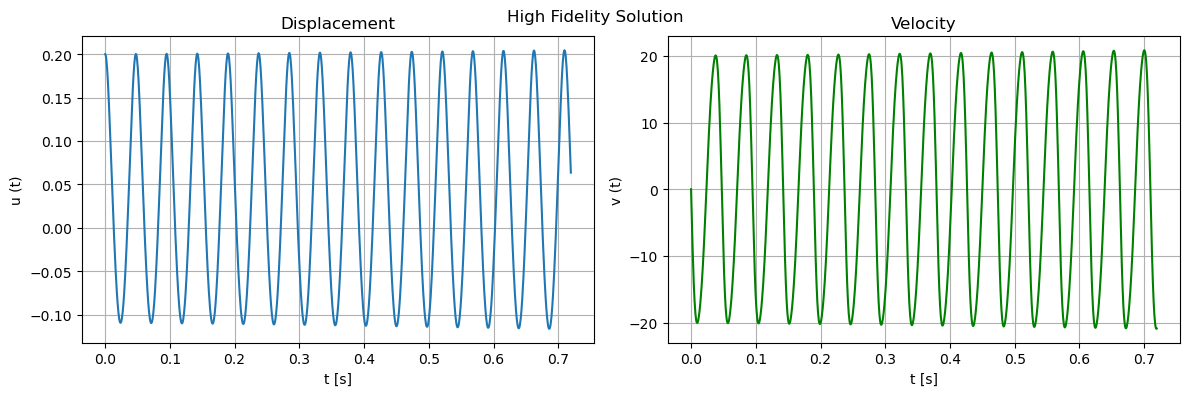

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(input_t, input_data[0, :],);
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("u (t)");
ax[0].set_title("Displacement");

ax[1].plot(input_t, input_data[1, :], 'g');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("v (t)");
ax[1].set_title("Velocity");

plt.tight_layout();
fig.suptitle("High Fidelity Solution");

**Organizing training data**

We will train our ROM on snapshots of $$
\pmb{X} = 
\begin{pmatrix}
u^k  \\
(u^k)²  \\
(u^k)^3  \\
1  \\
\end{pmatrix} and \; \pmb{Y} = \begin{pmatrix}
\dot{v}^k  \\
\end{pmatrix}$$

We thus expect from the ROM to learn the model parameters:
$$ \pmb{A} = 
\begin{pmatrix}
a & b & c & d
\end{pmatrix}
$$


In [32]:
Coeff = 0.5
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1]))], 
               "Y" : [lambda x : v_dot(x, train_t)]}

**Extended DMD learns:**

In [33]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables = observables)

The DMD operator is $\pmb{A}$ = 

In [34]:
edmd.A

array([[ -10089.46559813,   -8973.24012359, -299999.99999962,
            900.        ]])

and **[a, b, c, d]** for this case is

In [35]:
model_param(0)[:-2]

array([ -10089.46559813,   -8973.24012351, -300000.        ,
           900.        ])

**eDMD did indeed learn the model parameters precisely.**

**Extended DMD predicts:**

In [36]:
pred_t = input_t.copy()
input_ = np.vstack((input_data[0, :], input_data[0, :]**2, input_data[0, :]**3, np.ones((1,len(pred_t)))))
pred = np.real(drom.predict(pred_t, x_input = input_))

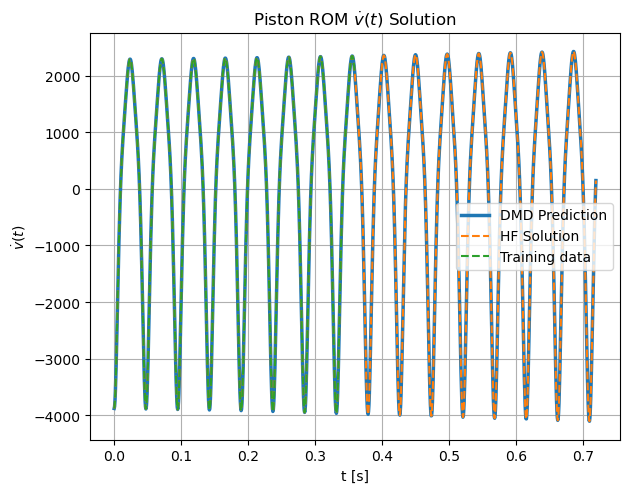

In [37]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, v_dot(Y[0, :], train_t), '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution"); 

**The results obtained from classical DMD would be erroneous** because the relationship between $\pmb{\dot{X}} = \begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix}$ and $\pmb{X} = \begin{pmatrix}
{u}(t)  \\
{v}(t)  \\
\end{pmatrix}$ is **nonlinear**, nonetheless the DMD learnt operator assumes linearity of the system. And even though the solution of $u(t)$ is a straightforward periodic function (See the figure above), the small dimension (2D) of the system compared to the number of timesteps makes it difficult for the DMD to accurately learn the system.

The goal then is to look for variables where we can wrote the system in a **linear** way, hence the use of **Extended DMD**, where we trained the eDMD to learn the linear system $\pmb{Y} = \pmb{A} \pmb{X}$ (as shown above). 

-----------------------------------------------------------------------------------------------------------------------------

The linear system we wrote was based on an *a priori* knowledge of the system, enabling us to use the obsevables, $u^2(t)$, $u^3(t)$ and $\dot{v}(t)$, the learning of the continuous system opertor also means we will have to solve a differential equation in order to find the $u(t)$ solution for future timesteps.

Two alternative solutions arise for this case:

   - Using the **Kernel DMD (KerDMD)**: Using well known kernels to make use of multiple observables, but only working on the reduced system (See  Williams et al., 2015). In fact the spring system can be apprixmated linearly if the chosen observables contain the polynomial terms of $u(t)$ and $(v(t)$ to the third order :  $\pmb{Y(X(t))} = \begin{pmatrix}
   1 \\
{u}(t)  \\
{v}(t)  \\
uv (t) \\
\vdots\\
u(t)^3\\
v(t)^3
\end{pmatrix}$, The obvious choice for the kernel would be the 3rd order polynomial kernel : $\pmb{f(X, Y)} = (1 + \pmb{X.T Y})^2$

In [38]:
"""The Y snapshots now are taken as the advanced X snapshots in time. 
Here we include the displcement u and velocity of the mass """

Coeff = 0.5
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:, :-1].reshape((2, -1))
Y = train_data[:, 1::].reshape((2, -1))

kdmd = KERDMD()
kdrom = ROM(kdmd)
kdrom.decompose(X = X, Y = Y, dt = dt, normalize=True, kernel = "poly", p=3)
kpred = np.real(kdrom.predict(pred_t,))

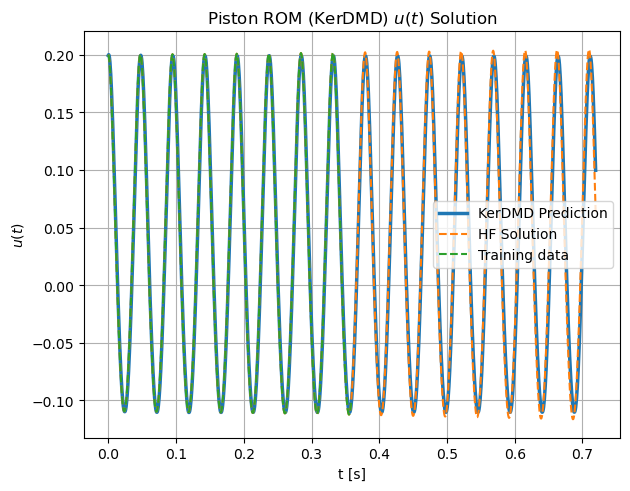

In [39]:
plt.plot(pred_t, kpred[0, :], linewidth = 2.5, label = 'KerDMD Prediction');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.plot(train_t[:-1], X[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$u (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM (KerDMD) $u (t)$ Solution"); 

The second altenrative solution:
   - Using the **High Order DMD (HoDMD)**: Leveraging the periodicity of the solution u(t), the classical DMD would be able to predict an accurate solution, but the small dimension of the system (dim = 2, u and v) hinders the DMD from accomplishing so. The workaround is using **High order DMD** (Le Clainche and Vega, 2017) that extends the DMD to cases where the spatial complexity is smaller than the spectral complexity (and hence the number of snapshots) : 

In [40]:
hodmd = HODMD()
horom = ROM(hodmd)
horom.decompose(X, Y=Y, dt = dt, hod=70, normalize=True)

In [41]:
pred_t = input_t.copy()
pred = np.real(horom.predict(pred_t,))

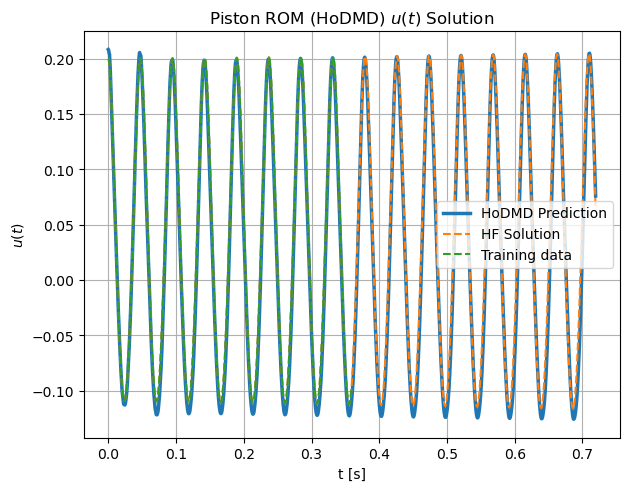

In [42]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'HoDMD Prediction');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.plot(train_t[:-1], X[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$u (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM (HoDMD) $u (t)$ Solution"); 

-----------------------------------------------------------------------------------------------------------------------------

## Unsteady pressure load p(t)

$$ p(t) = 10^6 sin(2\pi f_f t)$$
with $f_f$ is the frequency of the pressure load (In the context of the piston/gas test case, it represents the pressure wave frequency).
Choosing $f_f = 20 Hz$ creates a strong coupling between the springsystem and the exterior load, because it's close to the spring natural frequency (see the displacement plot)

In [43]:
input_data, input_t, dt, v_dot, model_param = create_data(4e6, 19)

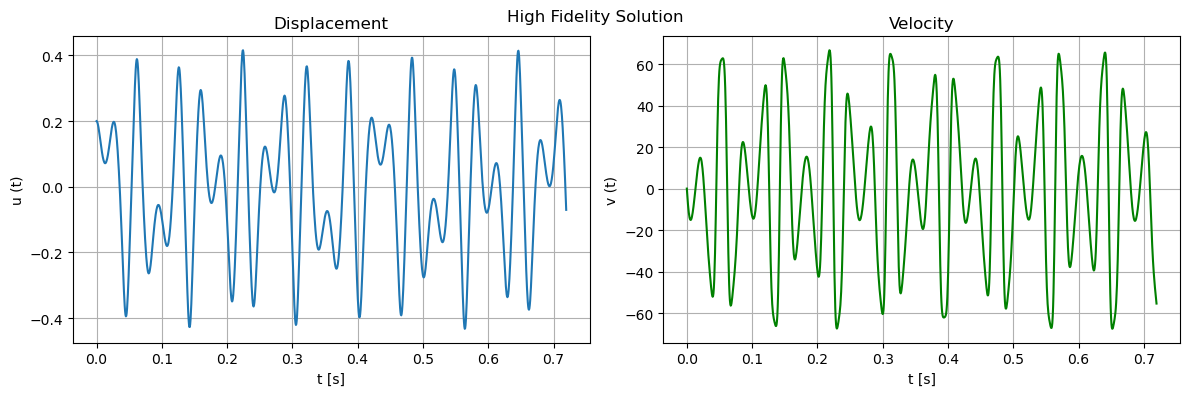

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(input_t, input_data[0, :],);
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("u (t)");
ax[0].set_title("Displacement");

ax[1].plot(input_t, input_data[1, :], 'g');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("v (t)");
ax[1].set_title("Velocity");

plt.tight_layout();
fig.suptitle("High Fidelity Solution");

In [45]:
Coeff = 0.35
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1]))], 
               "Y" : [lambda x : v_dot(x, train_t)]}

**eDMD learning:** At first we consider the same set of observables : 

$$
\pmb{X} = 
\begin{pmatrix}
u^k  \\
(u^k)²  \\
(u^k)^3  \\
1  \\
\end{pmatrix} and \; \pmb{Y} = \begin{pmatrix}
\dot{v}^k  \\
\end{pmatrix}$$

In [46]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [47]:
pred_t = input_t.copy()
input_ = np.vstack((input_data[0, :], input_data[0, :]**2, input_data[0, :]**3, np.ones((1,len(pred_t)))))
pred = np.real(drom.predict(pred_t, x_input = input_))

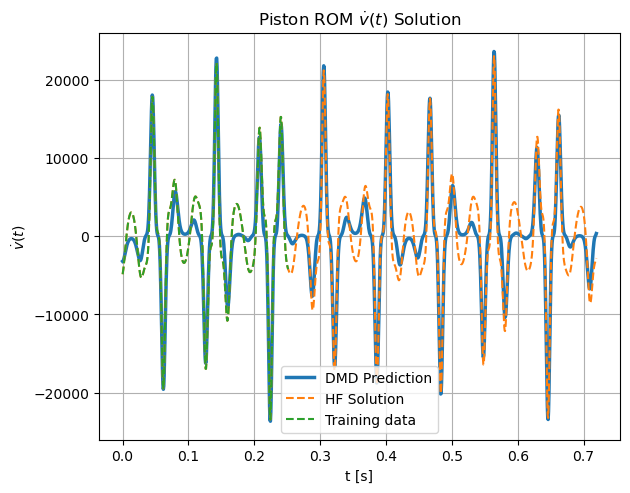

In [48]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, v_dot(Y[0, :], train_t), '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution"); 

**Add the pressure to the set of observables** : We consider now

$$
\pmb{X} = 
\begin{pmatrix}
u^k  \\
(u^k)²  \\
(u^k)^3  \\
1  \\
p^k \\
\end{pmatrix} and \; \pmb{Y} = \begin{pmatrix}
\dot{v}^k  \\
\end{pmatrix}$$

In [57]:
X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

p = lambda t : 4e6 * np.sin(2 * np.pi * 19 * t)
observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : p(train_t).reshape((1, -1))], 
               "Y" : [lambda x : v_dot(x, train_t)]}

In [58]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [59]:
pred_t = input_t.copy()
input_ = np.vstack((input_data[0, :], input_data[0, :]**2, input_data[0, :]**3, np.ones((1,len(pred_t))), p(input_t).reshape((1, -1))))
pred = np.real(drom.predict(pred_t, x_input = input_))

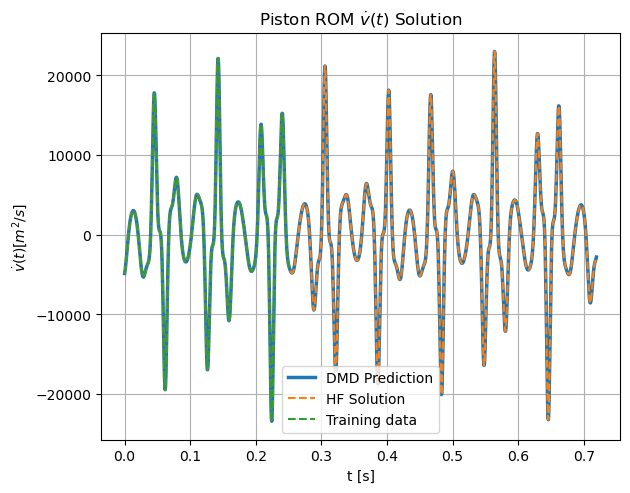

In [66]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, v_dot(Y[0, :], train_t), '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t) [m^2/s]$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution");

We notice an enhanced ROM solution. If we show the learned eDMD operator:

$\pmb{A} = $

In [61]:
edmd.A

array([[-1.00894658e+04, -8.97323405e+03, -2.99999997e+05,
        -1.00000261e+02,  1.00000000e-03]])

and **[a, b, c, $\pmb{d_1}$, $\pmb{d_2}$]** = 

In [62]:
model_param(0)[[0, 1, 2, 4, 5]]

array([-1.00894656e+04, -8.97324012e+03, -3.00000000e+05, -1.00000000e+02,
        1.00000000e-03])

With the learned model, and the predicted $v^k$ values, we can solve (ODE1) (See the first system) in order to compute $u^k$ values. Alternatively, for this case, Quasi-Newton schemes can be appplied to compute $u^k$ : 

In [63]:
import scipy.optimize as op

def fun(x, param_):
    return v_dot(x, param_) - pred[0, :]

res = op.newton(fun, np.zeros(pred[0, :].shape), args = (pred_t, ))

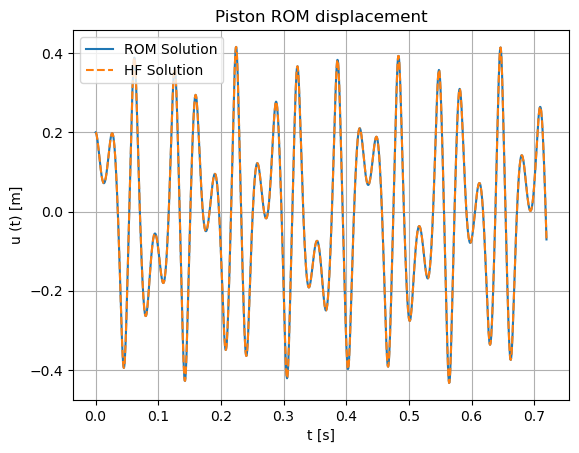

In [68]:
plt.plot(pred_t, res, label = 'ROM Solution');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.grid();
plt.ylabel("u (t) [m]");
plt.xlabel("t [s]");
plt.legend();
plt.title(r"Piston ROM displacement");